# Enoncé

Comme nous l'avons vu en cours,il est possible d'utiliser un type spécifique d'autoencoder pour générer de nouvelles données. Cette architecture est appellée VAE (Variationnal autoencoder). Cette architecture, comme beaucoup d'autres en Deep Learning) permet en modifiant la loss de forcer un comportement. Pour ce faire nous allons avoir un espace latent bien particulier. Celui-ci sera composé de deux vecteurs, un vecteur de moyennes et un vecteur d'écarts type (pour générer une distribution normale).

Le fait d'utiliser un espace latent qui s'exprime sous la forme d'une distribution normale nous permet, en choisissant des cooronnées aléatoires dans cette distribution de générer un nouvel espace latent "facilement".

Ici, nous allons voir comment en introduisant de l'aléatoire nous pouvons choisir de générer une image particulière.

Pour le bon déroulement de ce TP nous allons une fois de plus travailler sur des données MNIST puisque la "simplicité" de ce jeu de donénes vous permet de générer de nouvelles images dans un temps très court.

Vous devrez, à l'aide des explications remplacer les "?". 

# 1.Import des librairies

In [1]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline
import os

Using TensorFlow backend.


In [2]:
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 10

# 2.Chargement des données MNIST

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])

# Normalize data
x_train = x_train.astype('float32') / x_train.max()
x_test = x_test.astype('float32') / x_test.max()

input_shape = (original_dim, )

# 3.Définition des fonctions utils

In [4]:
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1] # Returns the shape of tensor or variable as a tuple of int or None entries.
    #à l'aide de la fonction K.random_normal, générer une distribution en vous appuyant sur les tensors déclarés au dessus :
    epsilon = K.random_normal([batch, dim])  # todo : not sure
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# 4.Architecture

Nous allons créer l'encoder et le decoder. On s'appuira sur ce schéma : https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png


In [9]:
# VAE model = encoder + decoder
# build encoder model
def encoder_model(inputs):
    x = Dense(intermediate_dim, activation='relu')(inputs)
    #on force le réseau à avoir deux espaces latents
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    # A l'aide de la fonction Lambda de Keras on va utiliser la fonction sampling que l'on a définit plus haut
    z = Lambda(sampling)((z_mean, z_log_var))
    
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    return encoder, z_mean, z_log_var

# build decoder model
def decoder_model():
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)
    outputs = Dense(original_dim, activation='sigmoid')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    return decoder


## Instantiation de l'encoder

In [10]:
inputs = Input(shape=input_shape, name='encoder_input')
encoder, z_mean, z_log_var = encoder_model(inputs)
encoder.summary()

ValueError: Layer lambda_3 was called with an input that isn't a symbolic tensor. Received type: <class 'tuple'>. Full input: [(<tf.Tensor 'z_mean_2/BiasAdd:0' shape=(?, 2) dtype=float32>, <tf.Tensor 'z_log_var_2/BiasAdd:0' shape=(?, 2) dtype=float32>)]. All inputs to the layer should be tensors.

## Déclaration du decoder

In [16]:
decoder = decoder_model()
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_4 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


# Merge

In [19]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[-1])
vae = Model(inputs, outputs, name='vae_mlp')

In [20]:
vae.summary()

Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


## Définition de la loss

Maintenant que nous avons défini notre modèle, nous pouvons procéder à la configuration du modèle. Habituellement, avec les réseaux de neurones, cela se fait avec model.compile, où une fonction de coût est spécifiée comme la crossentropie binaire. Cependant, pour les VAE ce n'est pas une simple fonction de perte(coût) qui est utilisée : nous utilisons la perte de reconstruction (dans notre cas, la perte de crossentropie binaire) en même temps que la perte de divergence KL pour nous assurer que notre espace latent est à la fois continu et complet. Dans l'intuition cela permet de forcer notre espace latent à être sous la forme d'une distribution normale.

In [14]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


c:\users\pierre.leroy\appdata\local\continuum\miniconda3\envs\majeure_dl\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


# 5. Entrainement

In [17]:
vae.fit(x_train, y_train)
vae.save_weights('vae_mlp_mnist_latent_dim_%s.h5' %latent_dim)
# vae.load_weights('vae_mlp_mnist_latent_dim_2.h5')


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 15s 246us/step - loss: 51.8322 - val_loss: 44.1774
Epoch 2/10
60000/60000 [==============================] - 15s 248us/step - loss: 43.3475 - val_loss: 42.6330
Epoch 3/10
60000/60000 [==============================] - 16s 263us/step - loss: 42.2594 - val_loss: 41.9121
Epoch 4/10
60000/60000 [==============================] - 15s 254us/step - loss: 41.6046 - val_loss: 41.2602
Epoch 5/10
60000/60000 [==============================] - 15s 242us/step - loss: 41.1098 - val_loss: 40.9114
Epoch 6/10
60000/60000 [==============================] - 15s 244us/step - loss: 40.7322 - val_loss: 40.5634
Epoch 7/10
60000/60000 [==============================] - 15s 253us/step - loss: 40.3817 - val_loss: 40.2862
Epoch 8/10
60000/60000 [==============================] - 15s 251us/step - loss: 40.0770 - val_loss: 40.0727
Epoch 9/10
60000/60000 [==============================] - 15s 248us/step - lo

# 6.Prédictions

In [ ]:
encoder_input = np.expand_dims(x_test[0], axis = 0)
mean, var, z = encoder.predict(encoder_input)
decoded_output = decoder.predict(mean)

# 7.Visualisation des résultats

## Observation de l'espace latent

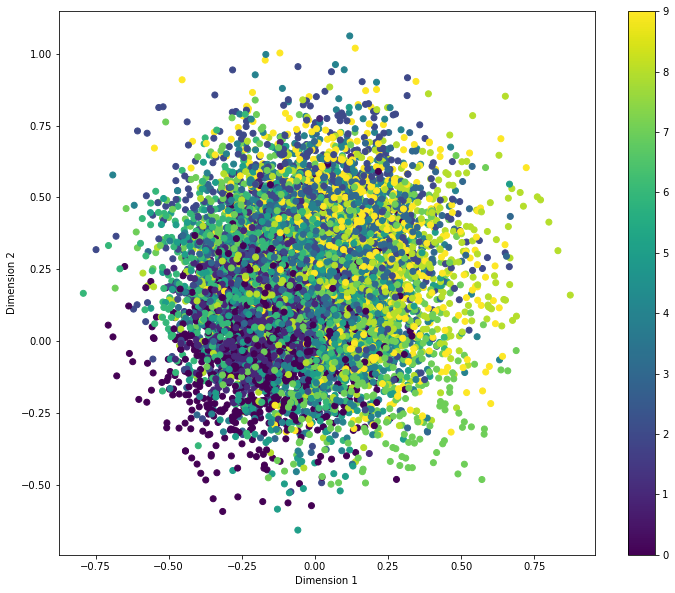

In [28]:

z_mean, _, _ = encoder.predict(x_test,
                               batch_size=batch_size)

model_name = 'vae_mnist'
os.makedirs(model_name, exist_ok=True)
filename = os.path.join(model_name, "vae_mean.png")

# display a 2D plot of the digit classes in the latent space
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
plt.colorbar()
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.savefig(filename)

## Affichage des sorties de notes modèle

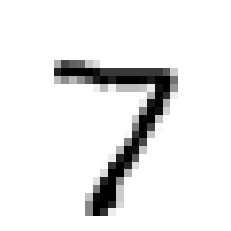

In [21]:
plt.ioff()
img = np.reshape(x_test[0], (image_size, image_size))
plt.axis('off')
plt.imshow(img, cmap = 'gray_r')
plt.savefig('seven_original.png')

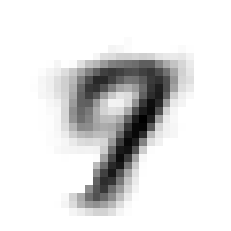

In [26]:
plt.ioff()
img = np.reshape(x_test[0], (image_size, image_size))
plt.axis('off')
plt.imshow(np.reshape(decoded_output, (image_size, image_size)), cmap = 'gray_r')
plt.savefig('seven_reproduced.png')

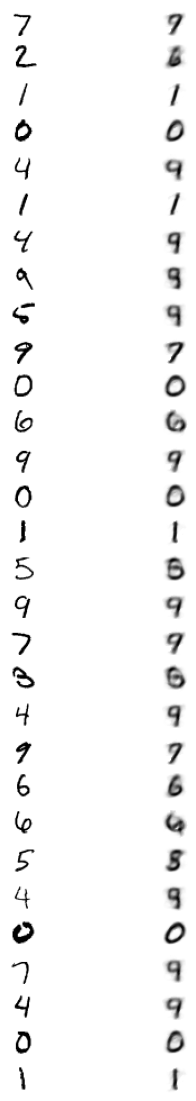

In [27]:
plt.ioff()
plt.figure(figsize=(5, 20))
for i in range(30):
    plt.subplot(30, 2, 2*i+1)
    img = np.reshape(x_test[i], (image_size, image_size))
    plt.axis('off')
    plt.imshow(img, cmap = 'gray_r')

    plt.subplot(30, 2, 2*i + 2)
    encoder_input = np.expand_dims(x_test[i], axis = 0)
    
    #Prédiction
    mean, var, z = encoder.predict(encoder_input)
    decoded_output = decoder.predict((mean, var, z))
    img = np.reshape(x_test[0], (image_size, image_size))
    plt.axis('off')
    plt.imshow(np.reshape(decoded_output, (image_size, image_size)), cmap = 'gray_r')
plt.savefig('mnist_reproduction.png')

<Figure size 600x400 with 0 Axes>

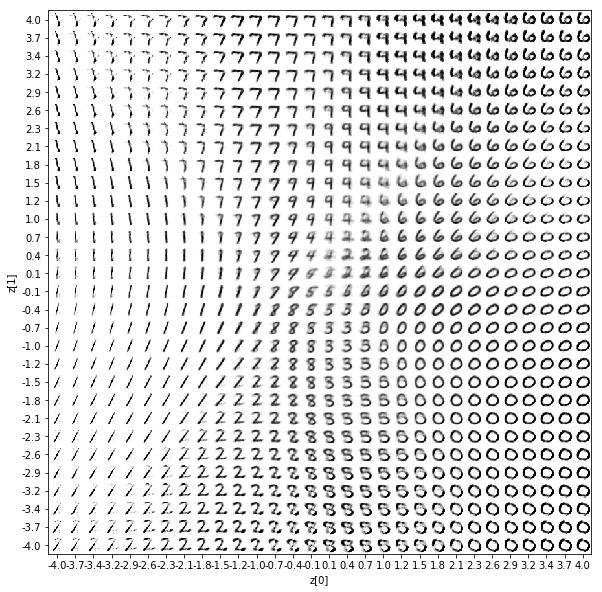

In [20]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]


for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.imshow(figure, cmap='gray_r')
